In [1]:
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", category=UserWarning)

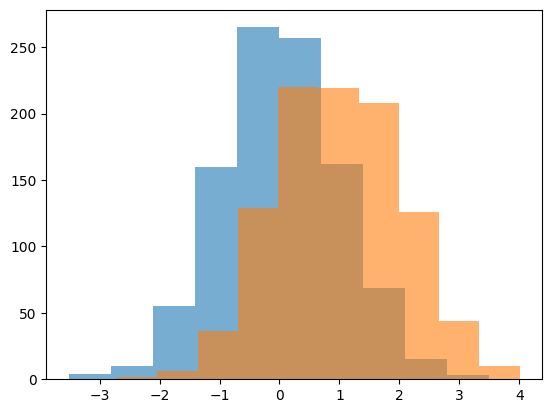

Difference between distributions (integral of absolute difference): 0.6961966099086517


In [2]:
# Example feature data (replace with your actual dataset features)
feature1 = np.random.normal(0, 1, 1000)  # Simulated feature 1
feature2 = np.random.normal(1, 1, 1000)  # Simulated feature 2

plt.hist(feature1, alpha=0.6)
plt.hist(feature2, alpha=0.6)

plt.show()

# Estimate PDFs using Kernel Density Estimation (KDE)
kde1 = stats.gaussian_kde(feature1)
kde2 = stats.gaussian_kde(feature2)

# Define the function to integrate (absolute difference of estimated PDFs)
def pdf_diff(x):
    return np.abs(kde1(x) - kde2(x))

# Define the integration range (from min to max of both datasets)
x_min = min(feature1.min(), feature2.min())
x_max = max(feature1.max(), feature2.max())

# Compute the integral
difference, _ = integrate.quad(pdf_diff, x_min, x_max)

print(f"Difference between distributions (integral of absolute difference): {difference}")

In [3]:
kde1.covariance

array([[0.0634261]])

In [4]:
import numpy as np
import torch
import torch.nn.functional as F

def matrix_kde_loss(features1, features2, bandwidth=0.1, num_points=100):
    """
    Computes the KDE loss for each feature dimension in a batched manner.
    
    Args:
        features1 (Tensor): First feature tensor of shape (N, D).
        features2 (Tensor): Second feature tensor of shape (M, D).
        bandwidth (float): Bandwidth for the Gaussian kernel.
        num_points (int): Number of points for numerical integration.
    
    Returns:
        Tensor: A tensor of shape (D,) representing KDE loss for each feature.
    """
    x_min = torch.min(features1.min(dim=0).values, features2.min(dim=0).values)
    x_max = torch.max(features1.max(dim=0).values, features2.max(dim=0).values)

    # Generate evaluation points for each feature dimension
    x_eval = torch.linspace(0, 1, num_points, device=features1.device).unsqueeze(1)  # (num_points, 1)
    x_eval = x_min + x_eval * (x_max - x_min)  # Rescale to feature-wise min/max -> (num_points, D)

    # Compute pairwise differences for KDE
    def kde(x, samples):
        diffs = x.unsqueeze(1) - samples.unsqueeze(0)  # (num_points, N, D)
        weights = torch.exp(-0.5 * (diffs / bandwidth) ** 2) / (bandwidth * (2 * torch.pi) ** 0.5)
        return weights.mean(dim=1)  # (num_points, D)

    kde1 = kde(x_eval, features1)
    kde2 = kde(x_eval, features2)

    # Compute absolute difference and approximate integral using trapezoidal rule
    pdf_diff = torch.abs(kde1 - kde2)
    dx = (x_max - x_min) / num_points
    integral = torch.sum(pdf_diff * dx, dim=0)  # (D,)

    return integral.sum()

data1 = torch.randn(1000, 10)
data2 = torch.randn(1000, 10)

# Compute batch KDE loss for all features and sum
total_loss = matrix_kde_loss(data1, data2)
print(total_loss)


tensor(1.2254)
